# 1. Análisis de los datos - Detección de *Fake News*

José Luis Aguilera Luzania

## Introducción

### ¿Qué es la detección de *Fake News*?
- Es la tarea de evaluar la veracidad de las afirmaciones en las noticias.
- Es un problema crítico en Procesamiento del Lenguaje Natural porque tanto en medios de noticias tradicionales como en medios digitales las Fake News generan un gran impacto social y político en cada individuo.
- La exposición a las Fake News puede generar actitudes de ineficacia, alienación y cinismo hacia ciertos candidatos políticos (Balmas, 2014).

### Objetivo de la libreta
El objetivo de esta libreta es proporcionar una análisis de los datos, su estructura e información básica antes de ser preprocesados.

## Análisis de los datos

### Librerías

- Manipulación de datos:
    - `pandas`: Librería para manipular los datos de forma tabular.
    - `matplotlib`: Librería para graficar.
    - `openpyxl`: Librería para leer archivos de hoja de cálculo en pandas.
    - `cmd`: Librería para controlar el formato de impresión en la consola.
    - `unicode`: Librería para eliminar acentos de las palabras.
    - `re`: Librería para utilizar expresiones regulares.
    
- Procesamiento del lenguaje natural:
    - `nltk`: Librería para utilizar técnicas de procesameinto del lenguaje natural.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import openpyxl
import cmd
import unidecode
import re
import nltk

### Datos adicionales para la librería `nltk`
- `punkt`: Necesario para utilizar el tokenizador de los textos.
- `stopwords`: Palabras comunes que no añaden información, como: el, la, los, etc.

In [3]:
# Descargar los datos necesarios.
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\JoseLuis_AL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JoseLuis_AL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Información del conjunto de datos

**Información general**  
- Se obtuvieron del repositorio de Github "FakeNewsCorpusSpanish" de J.P.Posadas. ([jpposadas](https://github.com/jpposadas/FakeNewsCorpusSpanish))
- Las noticias fueron recolectadas de enero a julio del 2018.
- Todas las noticias están escritas en el idioma español.
- El *corpus* contiene 971 noticias divididas en:
    - 491 noticias reales.
    - 480 noticias falsas.
    
**¿Cómo se etiquetaron los datos?**  
El proceso de etiquetación de las noticias fue manual y se tomaron en cuenta los siguientes aspectos:  

1. Una noticia es etiquetada como verdadera si hay evidencia de que fue publicada en sitios de confianza, periódicos establecidos o en páginas de periodistas renombrados.  
2. Una noticia es etiquetada como falsa si había noticias publicadas en sitios confiables o especializados en detección de contenido engañoso como VerificadoMX que contradicen la información o si no se encontró otra evidencia sobre la noticia.  
3. La correlación entre las noticias se mantuvo, recolectando un par Verdadera-Falsa de cada evento.  
4. Se buscó incluir la fuente original de cada noticia.

**Temas de las noticias**  
El *corpus* cubre noticias de 9 temas diferentes.

1. Ciencia.
2. Deportes.
3. Economía.
4. Entretenimiento.
5. Educación.
6. Política.
7. Salud.
8. Seguridad.
9. Sociedad

**Estructura de los datos**
- **Id**: Identificador de cada instancia.
- **Category**: Categoría de la noticia (True o False).
- **Topic**: Tema relacionado con la noticia.
- **Source**: Nombre de la fuente.
- **Headline**: Titulo de la noticia.
- **Text**: Texto de la noticia	.
- **Link**: URL de la fuente.

### Leer los datos

Los datos estan divididos en los archivos `train.xlsx` y `development.xlsx`, con 80% para entrenamiento y 20% para pruebas respectivamente.

Para cargar los conjuntos de datos se utilizará la librería `pandas` y su estructura `DataFrame`.

In [4]:
df_entrenamiento = pd.read_excel('Datos/train.xlsx')
df_pruebas = pd.read_excel('Datos/development.xlsx')

### Conjunto de entrenamiento

In [5]:
print(f'Noticias, Columnas: {df_entrenamiento.shape}')
print(f'Columnas: {list(df_entrenamiento.columns)}')
print('Noticias verdaderas: {}'.format(df_entrenamiento.groupby('Category').size()[0]))
print('Noticias falsas: {}'    .format(df_entrenamiento.groupby('Category').size()[1]))

Noticias, Columnas: (676, 7)
Columnas: ['Id', 'Category', 'Topic', 'Source', 'Headline', 'Text', 'Link']
Noticias verdaderas: 338
Noticias falsas: 338


### Conjunto de pruebas

In [6]:
print(f'Noticias, Columnas: {df_pruebas.shape}')
print(f'Columnas: {list(df_pruebas.columns)}')
print('Noticias verdaderas: {}'.format(df_pruebas.groupby('Category').size()[0]))
print('Noticias falsas: {}'    .format(df_pruebas.groupby('Category').size()[1]))

Noticias, Columnas: (295, 7)
Columnas: ['Id', 'Category', 'Topic', 'Source', 'Headline', 'Text', 'Link']
Noticias verdaderas: 142
Noticias falsas: 153


### Temas

Como se describió en la sección 2.3 el *corpus* cuenta con 9 temas, las noticias se encuentran distribuidas de la siguiente manera:

In [7]:
df_temas_entrenamiento = pd.DataFrame.from_dict(
    dict(df_entrenamiento.groupby('Topic').size()), 
    orient='index', 
    columns=['Entrenamiento'])

df_temas_pruebas = pd.DataFrame.from_dict(
    dict(df_pruebas.groupby('Topic').size()), 
    orient='index', 
    columns=['Pruebas'])

df_temas = pd.concat([df_temas_entrenamiento, df_temas_pruebas], axis=1)
df_temas.to_csv('Tablas-CSV/Temas-Noticias.csv')
df_temas

,Entrenamiento,Pruebas
Economy,30,13
Education,15,7
Entertainment,103,45
Health,32,14
Politics,226,97
Science,62,27
Security,29,13
Society,93,41
Sport,86,38


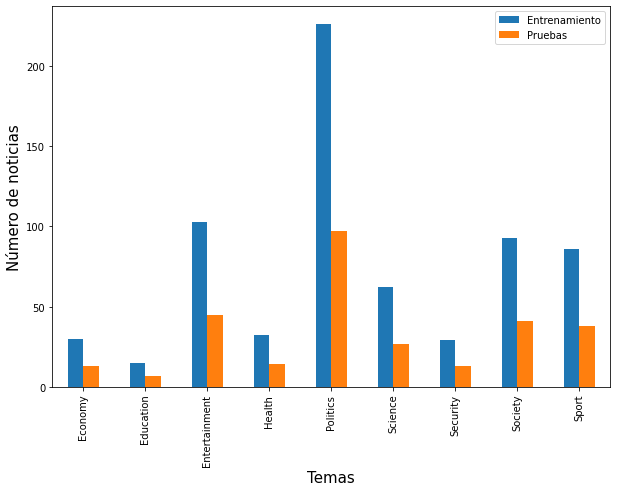

In [8]:
temas_plot = df_temas.plot(kind='bar', figsize=(10, 7))
temas_plot.set_xlabel('Temas', fontsize=15)
temas_plot.set_ylabel('Número de noticias', fontsize=15)

temas_plot.figure.savefig('Plots/Temas-Noticias.png')

### ¿Cuáles son las fuentes?

Para conocer todas las fuentes hay que hacer un preprocesado de los datos.

1. Concatenar los DataFrames de entrenamiento y pruebas.
1. Crear un nuevo DataFrame con las columnas `Category` y `Source`.
2. Crear una lista con las fuentes (columna `Source`).
3. Eliminar valores repetidos en la lista e imprimir el número de fuentes.
4. Imprimir los primeros 15.

In [9]:
# 1. Concatenamos los DataFrames de entrenamiento y pruebas.
df_datos = pd.concat([df_entrenamiento, df_pruebas], axis=0)

# 2. Separar los datos.
df_categoria_fuente = df_datos[['Category', 'Source']]

# 3. Todos los valores en la columna 'Source'.
fuentes_ls = df_categoria_fuente['Source'].to_list()

# 4. Eliminar valores repetidos e imprimir el número de fuentes.
fuentes_ls = list(sorted(set(fuentes_ls)))
print(f'Número de fuentes: {len(fuentes_ls)}')

# 5. Imprimir los primeros 15.
fuentes_ls[:15]

Número de fuentes: 167


['20 Minutos',
 'ABC',
 'ABC EL RECREO',
 'ABC Noticias',
 'ABC sociedad',
 'ANONYMOUS  AZTECA',
 'ARGUMENTO POLÍTICO',
 'Actualidad RT',
 'Alerta digital',
 'Animal Politico ',
 'Animal Político',
 'Animal político',
 'Argumento Político',
 'Aristegui Noticias',
 'Aristegui noticias']

**Fuentes repetidas**  

Se puede observar que existen fuentes repetidas en la lista como 'Animal Político' o 'Aristegui Noticias' porque no se escribieron de la misma manera, sin embargo, son la misma fuente de información.  

Para resolver este problema es necesaro crear una función para procesar el texto de las fuentes con las siguientes reglas:

1. Convertir todas las fuentes en minúsculas.
2. Eliminar acentos.
3. Eliminar todo excepto las palabras.

In [10]:
def procesar_fuentes(texto):
    '''
    Input: 
        texto: una cadena de texto.
        
    Output:
        texto: una cadena de texto formada solo por las palabras del texto original, sin acentos, caracteres especiales o espacios extra.
    '''
    # 1. Convertir el texto en minúsculas.
    texto = texto.lower()
    
    # 2. Eliminar acentos.
    texto = unidecode.unidecode(texto)
    
    # 3. Quedarnos solo con las palabras.
    texto = re.findall(r'\w+', texto)
    texto = ' '.join(texto)
    
    return texto

**Procesar todas las fuentes**  

1. Se aplica la función `procesar_fuentes` a la columna `Source`.
2. Crear una lista con las fuentes (columna `Source`).
3. Eliminar valores repetidos en la lista e imprimir el número de fuentes.
4. Imprimir los primeros 15.

In [11]:
# 1. Aplicar la función 'procesar_fuentes'.
fuentes_procesadas = df_categoria_fuente['Source'].apply(procesar_fuentes)

# 2. Crear una lista con las fuentes procesadas.
fuentes_procesadas_ls = fuentes_procesadas.to_list()

# 3. Eliminar valores repetidos e imprimir el número de fuentes.
fuentes_procesadas_ls = list(sorted(set(fuentes_procesadas_ls)))
print(f'Número de fuentes: {len(fuentes_procesadas_ls)}')

# 4. Imprimir las primeras 15 fuentes.
fuentes_procesadas_ls[:15]

Número de fuentes: 147


['20 minutos',
 'abc',
 'abc el recreo',
 'abc noticias',
 'abc sociedad',
 'actualidad rt',
 'alerta digital',
 'animal politico',
 'anonymous azteca',
 'argumento politico',
 'aristegui noticias',
 'azteca deporte',
 'bbc',
 'bbc news',
 'billboard']

In [12]:
print(f'Número de fuentes original: {len(fuentes_ls)}')
print(f'Número de fuentes real: {len(fuentes_procesadas_ls)}')

Número de fuentes original: 167
Número de fuentes real: 147


El número de fuentes original era 167, pero después de procesar los textos de las fuentes podemos observar que en realidad solo hay 147 fuentes en total, es decir, existen 20 fuentes que fueron escritas de forma incorrecta.

**Lista de fuentes**  

In [13]:
cli = cmd.Cmd()
cli.columnize(fuentes_procesadas_ls, displaywidth=130)

20 minutos                 dos mundos                 facebook el senor lopez  la verdad es           razon                  
abc                        eco portal                 facebook unico noticias  la voz popular         record                 
abc el recreo              eje central                fifa                     lamula                 resumen latinoamericano
abc noticias               el buen tono               fisgon politico          lo que calla la tv     retroceso              
abc sociedad               el clarin                  forbes                   los replicantes        rey misterios          
actualidad rt              el coleccionista de datos  frentes politicos        marca                  sabor a merengue       
alerta digital             el dizque                  grandes medios           medio tiempo           sdp noticias           
animal politico            el economista              grupo formula            mediterraneo digital   sdpnoticias     

### Fuentes con más *Fake News* y *True News* recolectadas

Lo siguiente es conocer son las fuentes de donde se obtuvieron más noticias verdaderas y falsas.  
Para esto debemos remplazar la columna de fuentes por la columna de fuentes procesadas con el fin de evitar fuentes duplicadas.

1. Crear un DataFrame con las fuentes procesadas.
2. Remplazar la columna de las fuentes originales en el DataFrame `df_categoria_fuente` con las fuentes procesadas.
4. Ordenar el DataFrame según la columna `Source` por orden alfabético.

In [14]:
# 1. Crear el DataFrame de las fuentes procesadas.
df_fuentes_procesadas = pd.DataFrame(fuentes_procesadas, columns=['Source'])

# 2. Remplazar la columna 'Source'.
df_categoria_fuente = df_categoria_fuente.assign(Source=df_fuentes_procesadas['Source'])

# 3. Ordenar los datos alfabéticamente según la columna 'Source'.
df_categoria_fuente = df_categoria_fuente.sort_values(by=['Source'], ascending=True)

**Calcular el número de noticias en base a la categoría**  
Para realizar esta tarea se crea la función `calcular_noticias`.

In [15]:
def calcular_noticias(dataframe, categoria):
    '''
    Input: 
        dataframe: DataFrame con los datos.
        categoria: categoría a la que pertenecen las noticias (True o Fake).
        
    Output:
        dict_noticias: diccionario donde las llaves son las fuentes y el valor es el número de veces que tuvo una noticia en la categoria.
    '''
    
    dict_noticias = dict()
    
    for df_categoria, df_fuente in dataframe.values:
    
        # Verificamos que sea la categoría deseada.
        if df_categoria == categoria:
        
            # Creamos una key para la fuente concatenando su valor de verdad.
            key_fuente = df_fuente + ' - ' + categoria

            # Si la key no se encuentra en el diccionario creamos una para cada categoria.
            if not key_fuente in dict_noticias:
                dict_noticias[key_fuente] = 0 

            dict_noticias[key_fuente] += 1
    
    return dict_noticias

**Fuentes con noticias falsas o *Fake News***

In [16]:
df_fuentes_fake = calcular_noticias(df_categoria_fuente, 'Fake')
df_fuentes_fake = pd.DataFrame(list(df_fuentes_fake.items()), columns=['Fuente', 'Cantidad'])
df_fuentes_fake = df_fuentes_fake.sort_values(by=['Cantidad'], ascending=False).reset_index().drop('index', axis=1)

df_fuentes_fake.head(10)

,Fuente,Cantidad
0,el dizque - Fake,135
1,el ruinaversal - Fake,94
2,hay noticia - Fake,39
3,censura 0 - Fake,36
4,la voz popular - Fake,24
5,modo noticia - Fake,22
6,retroceso - Fake,17
7,el mundo today - Fake,11
8,argumento politico - Fake,9
9,nacion unida - Fake,5


**Fuentes con noticias verdaderas o *True News***

In [17]:
df_fuentes_true = calcular_noticias(df_categoria_fuente, 'True')
df_fuentes_true = pd.DataFrame(list(df_fuentes_true.items()), columns=['Fuente', 'Cantidad'])
df_fuentes_true = df_fuentes_true.sort_values(by=['Cantidad'], ascending=False).reset_index().drop('index', axis=1)

df_fuentes_true.head(10)

,Fuente,Cantidad
0,el pais - True,80
1,el universal - True,68
2,excelsior - True,45
3,forbes - True,34
4,huffpost - True,26
5,proceso - True,25
6,el financiero - True,22
7,milenio - True,18
8,bbc news - True,17
9,aristegui noticias - True,14
